Training on 1164 houses
Testing on 292 houses
       Feature    Weight
0  OverallQual  0.117489
2   GarageCars  0.101440
4  SqFtPerRoom  0.000317
1    GrLivArea  0.000236
3  TotalBsmtSF  0.000201
R-Squared Score: 0.7989
RMSE (Log Sale Price): 0.1782


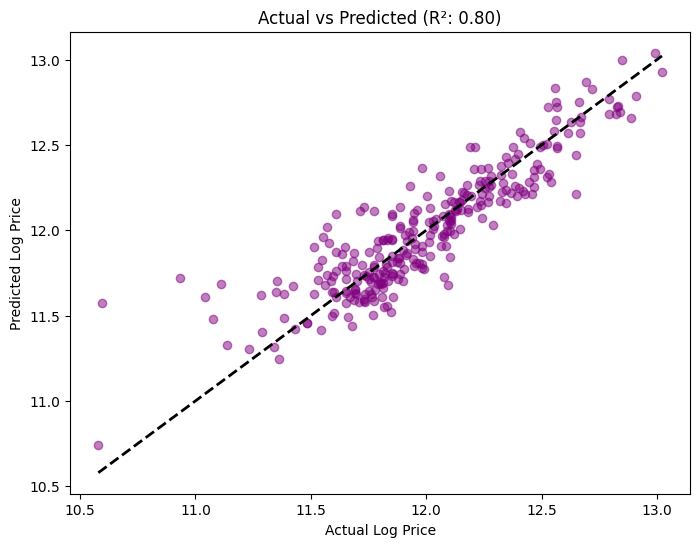

Average Error: $21456.33
New R-Squared: 0.8109 (Previous: 0.7989)
New RMSE: 0.1728 (Previous: 0.1782)
New Average Error: $21,093.48
Improvement: $362.85
Neighborhood R-Squared: 0.8713 (Previous: 0.8109)
Neighborhood RMSE: 0.1426
                 Feature    Weight
27  Neighborhood_StoneBr  0.168616
21  Neighborhood_NridgHt  0.152168
29  Neighborhood_Veenker  0.127774
26  Neighborhood_Somerst  0.108296
9   Neighborhood_ClearCr  0.093182
Final Average Error: $17,096.31
Total Improvement from Baseline: $4,360.02
FINAL R-Squared: 0.8748
FINAL Avg Dollar Error: $16,937.05


C:\Users\alist\AppData\Local\Temp\ipykernel_3064\1407887446.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Average Error: ${mean_dollar_error[0]:.2f}')


In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
import polars as pl

df_final_audit = pl.read_csv('../Data/train_cleaned.csv')

#recalculate LogSalePrice and SqFtPerRoom.
if 'LogSalePrice' not in df_final_audit.columns:
    df_final_audit = df_final_audit.with_columns(
        pl.col('SalePrice').log().alias('LogSalePrice')
    )

if 'SqFtPerRoom' not in df_final_audit.columns:
    df_final_audit = df_final_audit.with_columns(
        (pl.col('GrLivArea')/pl.col('TotRmsAbvGrd')).alias('SqFtPerRoom')
    )


#starting with our top 5 features and our engineerd one
features = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'SqFtPerRoom']

x = df_final_audit.select(features).to_pandas()
y = df_final_audit.select('LogSalePrice').to_pandas()

#train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print(f'Training on {x_train.shape[0]} houses')
print(f'Testing on {x_test.shape[0]} houses')

#fit model
model = LinearRegression()
model.fit(x_train, y_train)

#table of importance
importance = pd.DataFrame({'Feature': features, 'Weight': model.coef_[0]})
print(importance.sort_values(by='Weight', ascending=False))

#Evaluation: Do these weights work on houses we haven't seen yet?
#make predictions on test set
y_pred = model.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'R-Squared Score: {r2:.4f}')
print(f'RMSE (Log Sale Price): {rmse:.4f}')

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Log Price')
plt.ylabel('Predicted Log Price')
plt.title(f'Actual vs Predicted (R²: {r2:.2f})')
plt.show()

#our RMSE stands at 0.1782 (17.82% since we're in log), we want to see the dollar value
y_actual_dollars = np.exp(y_test)
y_pred_dollars = np.exp(y_pred)

dollar_error = np.abs(y_actual_dollars - y_pred_dollars)
mean_dollar_error = dollar_error.mean()

print(f'Average Error: ${mean_dollar_error[0]:.2f}')

# 1. Update your feature list
features_v2 = ["OverallQual", "OverallCond", "GrLivArea", "GarageCars", "TotalBsmtSF", "SqFtPerRoom"]

X_v2 = df_final_audit.select(features_v2).to_pandas()
y_v2 = df_final_audit.select("LogSalePrice").to_pandas()

# 2. Split again (keep random_state=42 so the 'test' houses are the same ones as before!)
X_train_v2, X_test_v2, y_train_v2, y_test_v2 = train_test_split(X_v2, y_v2, test_size=0.2, random_state=42)

# 3. Train the new model
model_v2 = LinearRegression()
model_v2.fit(X_train_v2, y_train_v2)

# 4. Predict and Score
y_pred_v2 = model_v2.predict(X_test_v2)
r2_v2 = r2_score(y_test_v2, y_pred_v2)
rmse_v2 = np.sqrt(mean_squared_error(y_test_v2, y_pred_v2))

print(f"New R-Squared: {r2_v2:.4f} (Previous: 0.7989)")
print(f"New RMSE: {rmse_v2:.4f} (Previous: 0.1782)")

y_actual_v2 = np.exp(y_test_v2)
y_pred_v2_dollars = np.exp(y_pred_v2)
new_dollar_error = np.abs(y_actual_v2 - y_pred_v2_dollars).mean().values[0]

improvement = 21456.33 - new_dollar_error
print(f"New Average Error: ${new_dollar_error:,.2f}")
print(f"Improvement: ${improvement:,.2f}")

# 1. Select our base numeric features + the Neighborhood column
features_v3 = ["OverallQual", "OverallCond", "GrLivArea", "GarageCars", "TotalBsmtSF", "SqFtPerRoom", "Neighborhood"]

# 2. Get the data and convert to dummies
# drop_first=True prevents the "Dummy Variable Trap" (multicollinearity)
X_v3 = df_final_audit.select(features_v3).to_pandas()
X_v3 = pd.get_dummies(X_v3, columns=["Neighborhood"], drop_first=True)

y_v3 = df_final_audit.select("LogSalePrice").to_pandas()

# 3. Split (still using 42 to keep our 'Test' houses consistent)
X_train_v3, X_test_v3, y_train_v3, y_test_v3 = train_test_split(X_v3, y_v3, test_size=0.2, random_state=42)

# 4. Train
model_v3 = LinearRegression()
model_v3.fit(X_train_v3, y_train_v3)

# 5. Predict and Score
y_pred_v3 = model_v3.predict(X_test_v3)
r2_v3 = r2_score(y_test_v3, y_pred_v3)
rmse_v3 = np.sqrt(mean_squared_error(y_test_v3, y_pred_v3))

print(f"Neighborhood R-Squared: {r2_v3:.4f} (Previous: 0.8109)")
print(f"Neighborhood RMSE: {rmse_v3:.4f}")

# See the top 5 'Value-Add' Neighborhoods
neigh_weights = pd.DataFrame({'Feature': X_v3.columns, 'Weight': model_v3.coef_[0]})
print(neigh_weights[neigh_weights['Feature'].str.contains('Neighborhood')].sort_values(by='Weight', ascending=False).head(5))

# Calculate dollar error
y_actual_v3 = np.exp(y_test_v3)
y_pred_v3_dollars = np.exp(y_pred_v3)
final_dollar_error = np.abs(y_actual_v3 - y_pred_v3_dollars).mean().values[0]

print(f"Final Average Error: ${final_dollar_error:,.2f}")
print(f"Total Improvement from Baseline: ${21456.33 - final_dollar_error:,.2f}")

# 1. Calculate Effective Age: YearSold - YearRemodAdd
# (If a house was never remodeled, YearRemodAdd equals YearBuilt)
df_final_audit = df_final_audit.with_columns(
    (pl.col("YrSold") - pl.col("YearRemodAdd")).alias("EffectiveAge")
)

# 2. Update Feature List for the Final Model
features_final = ["OverallQual", "OverallCond", "GrLivArea", "GarageCars", 
                  "TotalBsmtSF", "SqFtPerRoom", "EffectiveAge", "Neighborhood"]

X_final = df_final_audit.select(features_final).to_pandas()
X_final = pd.get_dummies(X_final, columns=["Neighborhood"], drop_first=True)

y_final = df_final_audit.select("LogSalePrice").to_pandas()

# 3. Final Train-Test Split & Model
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

final_model = LinearRegression()
final_model.fit(X_train_f, y_train_f)

# 4. Final Scoring
y_pred_f = final_model.predict(X_test_f)
r2_f = r2_score(y_test_f, y_pred_f)
y_pred_f_dollars = np.exp(y_pred_f)
final_avg_error = np.abs(np.exp(y_test_f) - y_pred_f_dollars).mean().values[0]

print(f"FINAL R-Squared: {r2_f:.4f}")
print(f"FINAL Avg Dollar Error: ${final_avg_error:,.2f}")